In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("tf.__version__: {}".format(tf.__version__))


IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/content/drive/MyDrive/amogus/images",
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

tf.__version__: 2.8.2
Found 2740 files belonging to 2 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                              shuffle=True, shuffle_size=10000):
  
    ## train-test-validation split function
      
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
        
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
## split dataset into training, validation, and testing datasets

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
## train, validation, and test dataset size, respectively

len(train_ds) * 32, len(val_ds) * 32, len(test_ds) * 32

(2176, 256, 320)

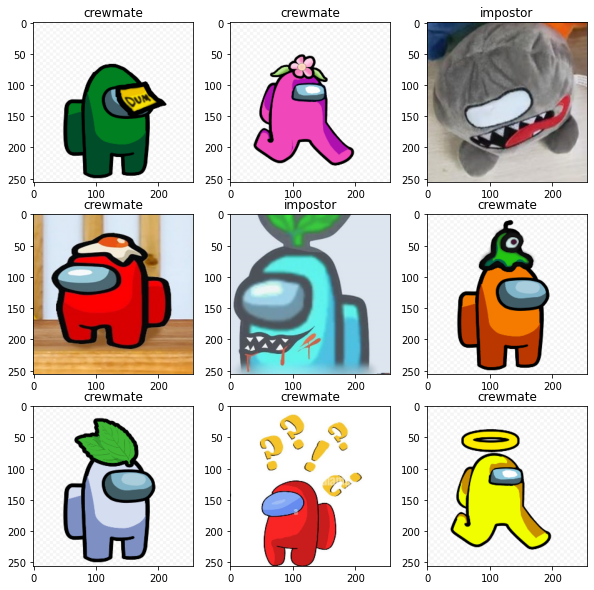

In [ ]:
## visualize few images from training dataset

import matplotlib.pyplot as plt

class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        # plt.axis("off")

In [ ]:
## optimize dataset for training performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
## use prebuilt input processing of mobilenet_v2 model architecture

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## data augmentation pipeline

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

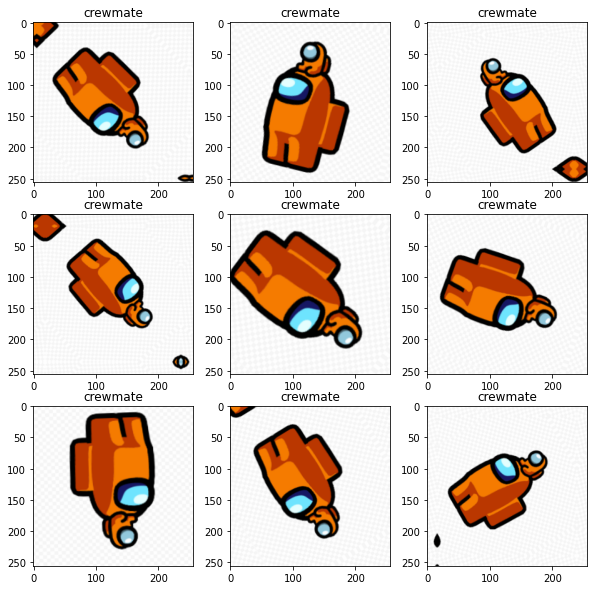

In [ ]:
## visualize augmented images

import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        # plt.axis("off")

In [ ]:
INPUT_SHAPE = IMAGE_SIZE + (CHANNELS,)

# Create the base model from the pre-trained model MobileNetV2

base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",             
    input_shape=INPUT_SHAPE,
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False

# check base model architecture summary
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
# Create new model on top
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)
x = data_augmentation(x)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(200, activation="relu"),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")                                 
])(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

import os
MODELS_DIR = os.path.join("/content/drive/MyDrive/amogus", "models")
os.makedirs(MODELS_DIR, exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "mobilenetv2/0001"), save_best_only=True)

base_epochs = 50
base_history = model.fit(train_ds, epochs=base_epochs, validation_data=val_ds, 
          callbacks=[checkpoint_cb])

Epoch 1/50
68/68 [==============================] - 78s 950ms/step - loss: 0.6021 - binary_accuracy: 0.7056 - precision: 0.6099 - recall: 0.5819 - val_loss: 0.4522 - val_binary_accuracy: 0.7787 - val_precision: 0.8438 - val_recall: 0.5510
Epoch 2/50
68/68 [==============================] - 25s 379ms/step - loss: 0.4235 - binary_accuracy: 0.8119 - precision: 0.7466 - recall: 0.7494 - val_loss: 0.3921 - val_binary_accuracy: 0.8525 - val_precision: 0.8523 - val_recall: 0.7653
Epoch 3/50
68/68 [==============================] - 25s 375ms/step - loss: 0.4030 - binary_accuracy: 0.8360 - precision: 0.7774 - recall: 0.7841 - val_loss: 0.3920 - val_binary_accuracy: 0.8402 - val_precision: 0.8831 - val_recall: 0.6939
Epoch 4/50
68/68 [==============================] - 24s 362ms/step - loss: 0.3755 - binary_accuracy: 0.8410 - precision: 0.7743 - recall: 0.8089 - val_loss: 0.3797 - val_binary_accuracy: 0.8238 - val_precision: 0.8667 - val_recall: 0.6633
Epoch 5/50
68/68 [==========================

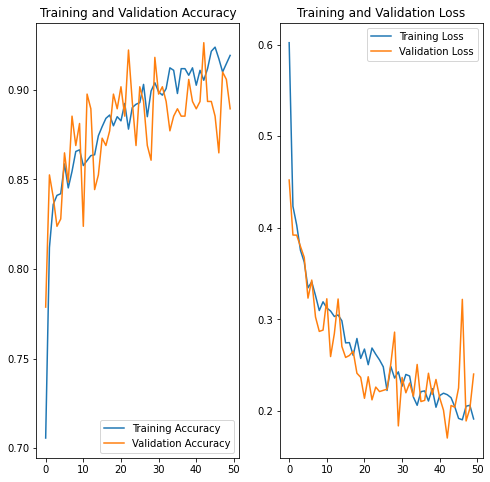

In [ ]:
def plot_learning_curves(history, epochs):
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs_range = range(epochs)
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_learning_curves(base_history.history, base_epochs)

In [ ]:
def get_y_test_y_pred(model, test_ds):

  y_true = list()
  y_pred = list()

  for x, y in test_ds:
    y_true.append(y)
    y_pred.append((model.predict(x) > 0.5).astype(np.uint32))
  
  y_true = tf.concat(y_true, axis=0)
  y_pred = tf.concat(y_pred, axis=0)

  return y_true, y_pred


# load model that performed best in validation during training
modelnetv2_0001 = tf.keras.models.load_model(os.path.join(
    MODELS_DIR, "mobilenetv2/0001"))
y_test, y_pred = get_y_test_y_pred(modelnetv2_0001, test_ds)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       201
           1       0.91      0.89      0.90       119

    accuracy                           0.93       320
   macro avg       0.93      0.92      0.92       320
weighted avg       0.93      0.93      0.93       320



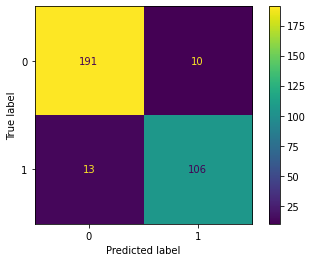

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# check base model architecture summary
base_model.summary()

Number of layers in the base model:  154
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )     

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  ## lower learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
     metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
)

model.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "mobilenetv2/0002"), 
    save_best_only=True)

fine_epochs = 100
fine_history = model.fit(train_ds, epochs=fine_epochs, validation_data=val_ds, 
                         callbacks=[checkpoint_cb])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

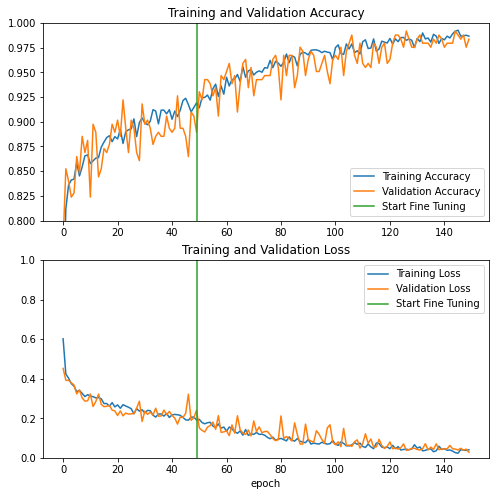

In [ ]:
## combine and plot base and fine-tuned model training history

acc = base_history.history["binary_accuracy"] + \
      fine_history.history["binary_accuracy"]
val_acc = base_history.history["val_binary_accuracy"] + \
          fine_history.history["val_binary_accuracy"]
loss = base_history.history["loss"] + fine_history.history["loss"]
val_loss = base_history.history["val_loss"] + fine_history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([base_epochs-1, base_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([base_epochs-1, base_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       201
           1       0.97      0.96      0.96       119

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



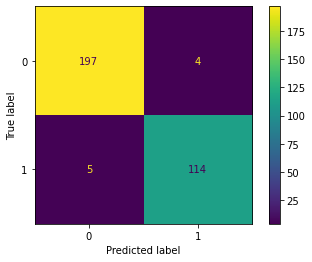

In [ ]:
# load model that performed best in validation during training
modelnetv2_0002 = tf.keras.models.load_model(
    os.path.join(MODELS_DIR, "mobilenetv2/0002"))
y_test, y_pred = get_y_test_y_pred(modelnetv2_0002, test_ds)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

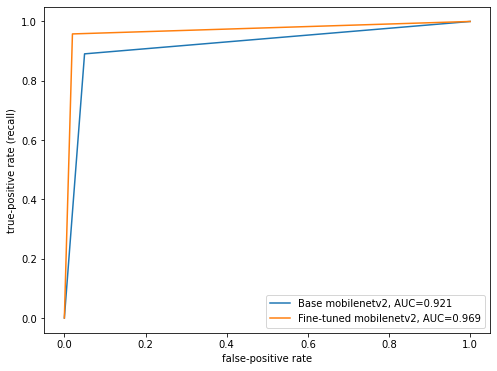

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#set up plotting area
plt.figure(figsize=(8, 6))

y_test, y_pred_bm = get_y_test_y_pred(modelnetv2_0001, test_ds)
fpr, tpr, _ = roc_curve(y_test, y_pred_bm)
auc = round(roc_auc_score(y_test, y_pred_bm), 3)
plt.plot(fpr,tpr,label="Base mobilenetv2, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
y_test, y_pred_fm = get_y_test_y_pred(modelnetv2_0002, test_ds)
fpr, tpr, _ = roc_curve(y_test, y_pred_fm)
auc = round(roc_auc_score(y_test, y_pred_fm), 3)
plt.plot(fpr,tpr,label="Fine-tuned mobilenetv2, AUC="+str(auc))

plt.xlabel("false-positive rate")
plt.ylabel("true-positive rate (recall)")

#add legend
plt.legend()

In [ ]:
def predict(model, img, threshold=0.5):

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # create a bactch

  raw_prediction = model.predict(img_array)[0][0]
  prediction = 1 if raw_prediction > threshold else 0
  class_name = class_names[prediction]
  confidence = (1 - raw_prediction) * 100 if prediction == 0 else (raw_prediction * 100)

  return class_name, round(confidence, 2)

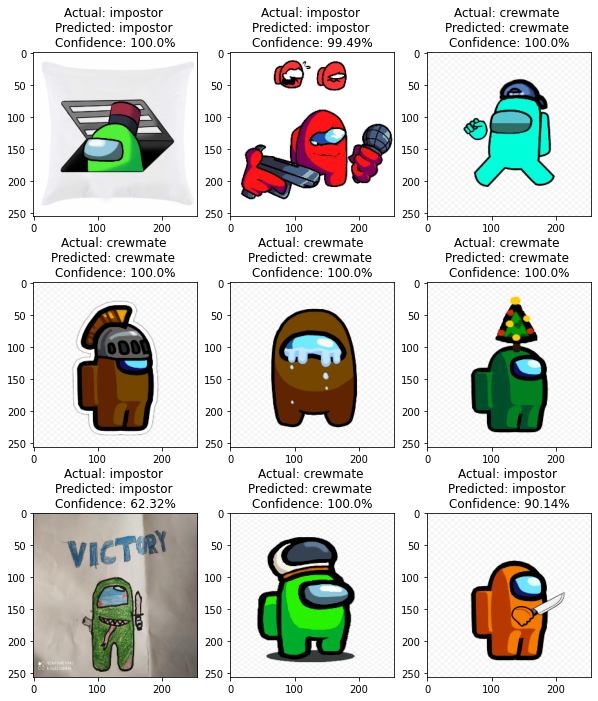

In [ ]:
plt.figure(figsize=(10, 12))

for images, labels in test_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_name, confidence  = predict(model, images[i].numpy())
      actual_class = class_names[labels[i]]
      plt.title(f"Actual: {actual_class} \nPredicted: {class_name} \nConfidence: {confidence}%")

In [ ]:
## save models to h5 format

modelnetv2_0001.save(os.path.join(MODELS_DIR, "mobilenetv2/amogus_classifier_0001.h5"))
modelnetv2_0002.save(os.path.join(MODELS_DIR, "mobilenetv2/amogus_classifier_0002.h5"))